In [1]:
###### set environment and load rdata
library(tidyverse)
library(survival)
library(survminer)
library("ggplot2")
library("ggpubr")
library(gridExtra)
library(ggrepel)
library("cowplot")
library(RColorBrewer)
library(ComplexHeatmap)
library(grid)
library(dplyr)
library(patchwork)
library(ggpmisc)
library(ggsci)
library(corrplot)
library(cowplot)
library(openxlsx)
library(reshape2)

Warning message:
"package 'tidyverse' was built under R version 4.2.3"
Warning message:
"package 'ggplot2' was built under R version 4.2.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggpubr


Attaching package: 'survminer'


The following object is masked from 'package:survival':

    myeloma



Attaching package: 'gridExtra'


The following object is masked from 

# step1

In [4]:
#source("reviewer_v2_mo/RCS_source/escc_function.r")
#load("reviewer_v2_mo/RCS_source/mobster_primary_no_pub_SNP_ZY.RData")

source("escc_function.r")
load("mobster_primary_no_pub_SNP_ZY.RData")

Warning message:
"package 'sads' was built under R version 4.2.3"
Loading required package: bbmle

Warning message:
"package 'bbmle' was built under R version 4.2.3"
Loading required package: stats4


Attaching package: 'bbmle'


The following object is masked from 'package:dplyr':

    slice


Warning message:
"package 'MASS' was built under R version 4.2.3"

Attaching package: 'MASS'


The following object is masked from 'package:patchwork':

    area


The following object is masked from 'package:dplyr':

    select


Warning message:
"namespace 'mobster' is not available and has been replaced
by .GlobalEnv when processing object 'plot1'"


In [6]:
###clonaility score, cs at sample level
#escc_pi <- read.table("reviewer_v2_mo/RCS_source/ESCC_WES_TitanCNA_ABSOLUTE_purity_ploity_depth_choice.txt",header = T)
escc_pi <- read.table("ESCC_WES_TitanCNA_ABSOLUTE_purity_ploity_depth_choice.txt",header = T)
escc_pi<-escc_pi[grep("T[0-9]",escc_pi$sample),] #primary
escc_pi$patient=substring(escc_pi$sample,1,7)
pts=unique(escc_pi$patient)
cs_in=NULL
for (i in 1:length(plot1)) {
  #i=1
  if(!is.null(plot1[[i]])) {
    tmp=fscs(plot1[[i]])
    cs_in=rbind(cs_in,tmp)
  }
}
cs_in$patient=substring(cs_in$sample,1,7)

clonality_score=scs_score(cs_in[which(cs_in$N_sub>=10),]) #cs_in[which(cs_in$N_sub>30),]

In [8]:
##RCS at patient_level
M=aggregate(score~patient,clonality_score,median) ## mean
D=aggregate(score~patient,clonality_score,sd)  ##variance
MX=aggregate(score~patient,clonality_score,max)  ##variance
rcs_escc=data.frame(patient=pts)
colnames(rcs_escc)[1]="patient"
rcs_escc$Median_log10_scs=M$score[match(rcs_escc$patient,M$patient)]
rcs_escc$SD_log10_scs=D$score[match(rcs_escc$patient,D$patient)]
rcs_escc$SD_log10_scs[is.na(rcs_escc$SD_log10_scs)]=0
rcs_escc$max_log10_scs=MX$score[match(rcs_escc$patient,MX$patient)]

# step2: visualization

In [9]:
#source("reviewer_v2_mo/RCS_source/escc_function.r")
#setwd("D:/1.escc/writing/Revision/")
#load(file = "reviewer_v2_mo/RCS_source//escc_ci_info.RData")


source("escc_function.r")
#setwd("D:/1.escc/writing/Revision/")
load(file = "escc_ci_info.RData")

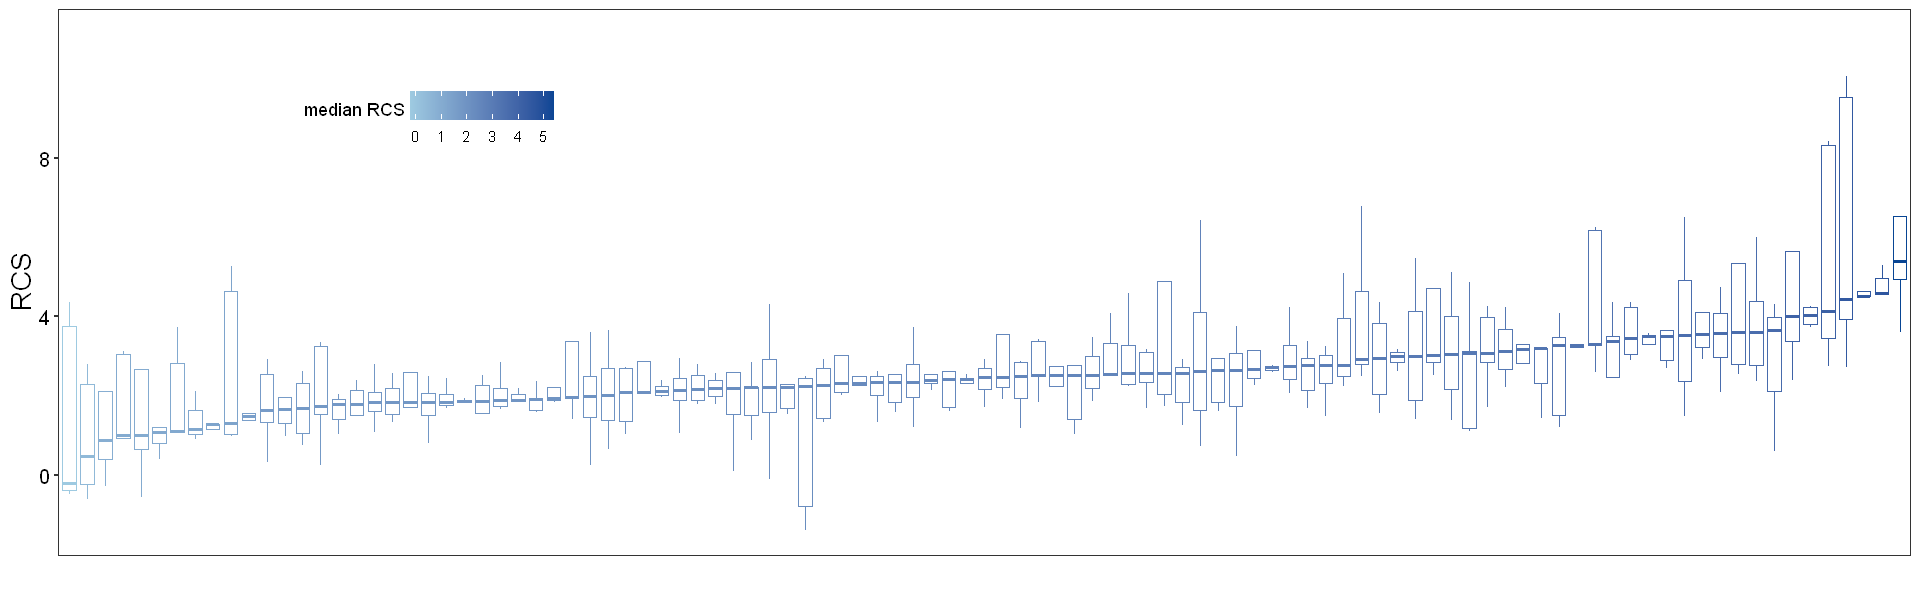

In [10]:
#part1.distribution of RCS
g1 <- sn_info %>% filter(grepl('T',Sample) & !is.na(log2_RCS) ) %>% group_by(Patient) %>% mutate(medRCS = median(log2_RCS)) %>%
  ggplot(aes(x = reorder(Patient,log2_RCS, FUN=median),y = log2_RCS))+ 
  geom_boxplot(aes(color=medRCS),outlier.colour="white", outlier.size=1) + labs(x = "", y = "RCS")+ #"#E41A1C"
  theme_bw()+theme(panel.grid = element_blank(),plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.2,0.8))+
  theme(axis.text.x=element_blank(),
    axis.text.y = element_text(size=12,colour = "black"),
    axis.ticks.y = element_line(linewidth =0.8),
    axis.ticks.x = element_blank(),
    axis.title = element_text(size=16,colour = "black")
  ) +scale_color_gradient(low = "#9ECAE1",high = "#084594")+
  guides(color=guide_colorbar(title="median RCS",title.vjust = 0.75,direction = "horizontal"))

options(repr.plot.width=16, repr.plot.height=5)
print(g1)

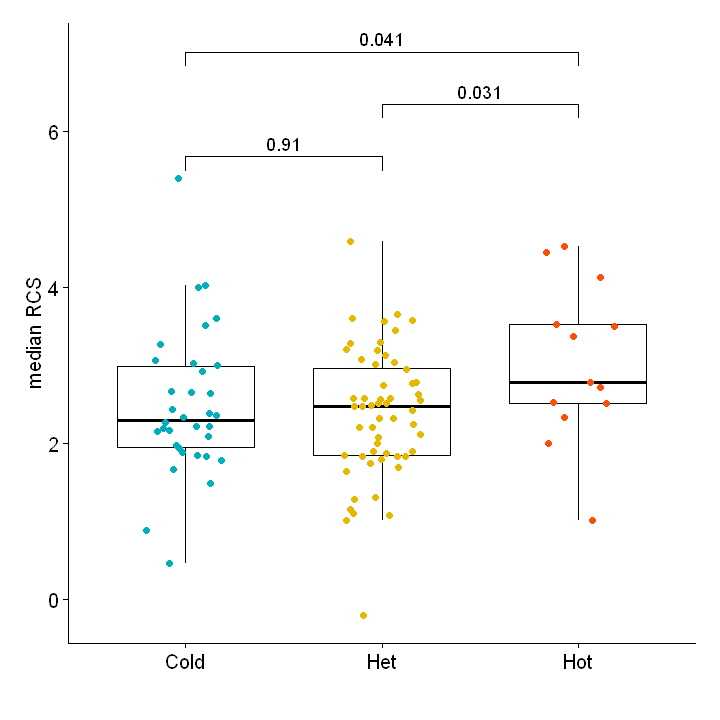

In [11]:
col=factor(ci_info$patient_CH)
levels(col)=c("#00AFBB", "#E7B800", "#FC4E07")
g2=ci_info %>% mutate(col=col) %>%
  ggboxplot( x = "patient_CH", y = "Median_log2_scs", color = "black",#palette = c("#00AFBB", "#E7B800", "#FC4E07"),
             legend="",add = "jitter", add.params = list(color = col),
            )+ylab("median RCS")+xlab("")+
  stat_compare_means(comparisons = list(c("Cold","Het"),c("Het","Hot"),c("Cold","Hot")), label = "p.format")+
  coord_cartesian(clip = "off") + ##避免注释看不清
  theme(plot.margin=unit(c(1,1,1,1),'lines'))

options(repr.plot.width=6, repr.plot.height=6)
print(g2)

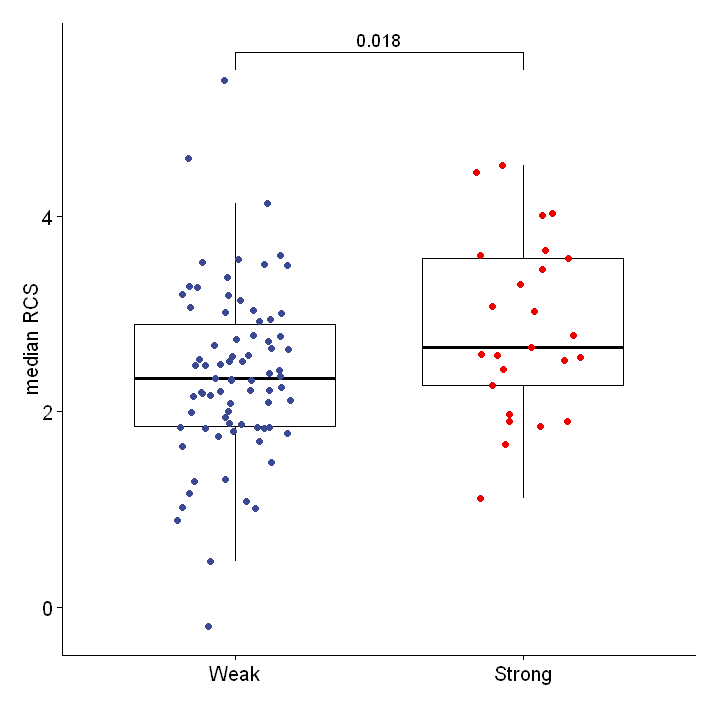

In [12]:
#Part3: IE vs RCS
library(ggsci)
col=factor(ci_info$IM_group,levels=c('Weak','Strong'))
levels(col)=pal_aaas()(2)
g3=ci_info %>% mutate(col=col) %>% ggboxplot( x = "IM_group", y = "Median_log2_scs", color = "black",#palette = "aaas",
         add = "jitter",xlab ="",ylab = "median RCS" ,legend="",
         add.params = list(color = col))+
  stat_compare_means(comparisons = list(c('Weak','Strong')), label = "p.format")+
  coord_cartesian(clip = "off") + ##避免注释看不清
  theme(plot.margin=unit(c(1,1,1,1),'lines'))
print(g3)

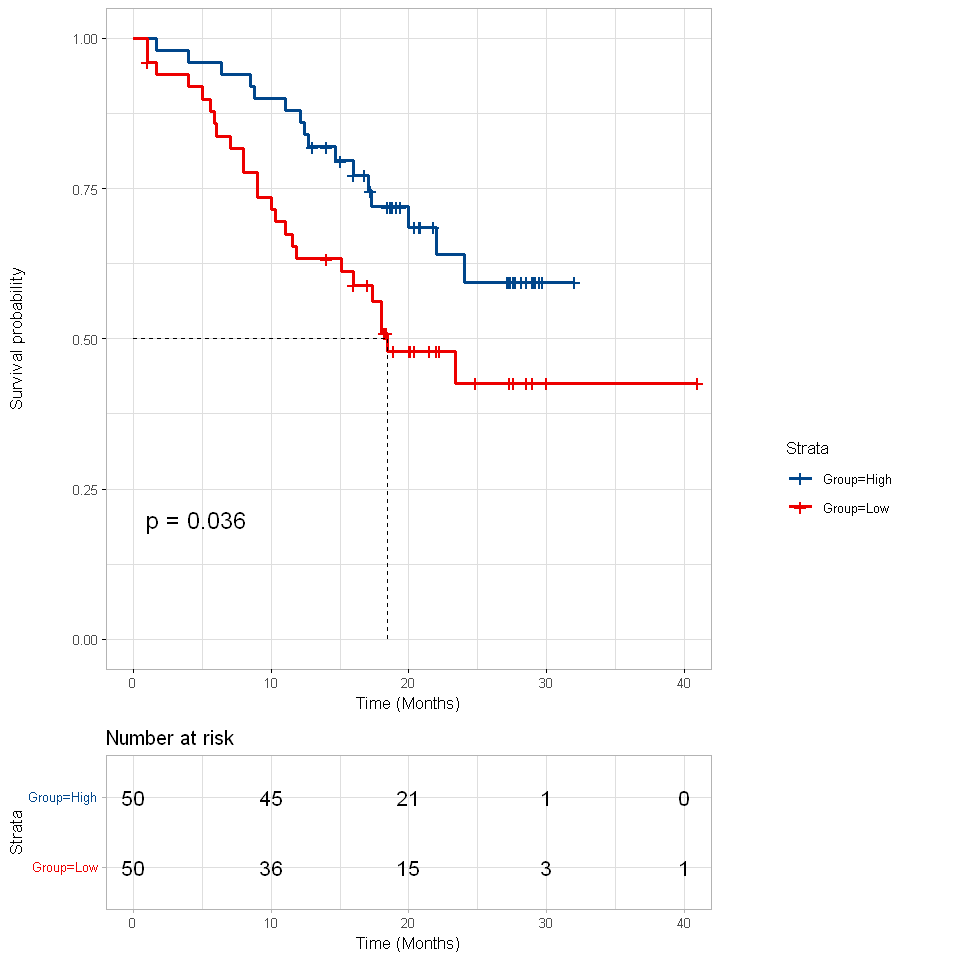

In [13]:
#Part4: Association RCS　with overall survival
item=as.numeric(ci_info$max_log2_scs) #
Data <- data.frame(
  sample = ci_info$Patients_ID,
  time = as.numeric(ci_info$time),
  status = as.numeric(ci_info$event),
  score=as.numeric(ci_info$max_log2_scs)
)
Data=na.omit(Data)
cutoff<-quantile(Data$score,probs = 0.5)
Data$Group = ifelse(Data$score > cutoff,"High","Low") 
Data$Group=as.factor(Data$Group)
survmax<-ggsurvplot(survfit(Surv(time, status) ~ Group, data = Data[-which(Data$sample %in% c("ESCC012","ESCC049","ESCC061") ),] ),
                    pval=TRUE,conf.int=FALSE,palette = "lancet",risk.table = TRUE,
                    surv.median.line="hv",pval.method = FALSE,xlab="Time (Months)",
                    ggtheme = theme_light(base_size = 10),legend="right")

options(repr.plot.width=8, repr.plot.height=8)

survmax